In [1]:
import numpy as np
import pandas as pd
import recommenders as rec
import networkx as nx
import matplotlib.pyplot as plt
import areamanager
import math
import timeit
import geo_utils
from constants import geocat_constants
from constants import experiment_constants
from constants import usg_constants
from collections import defaultdict
import utils
def string_to_array(string):
    if string == '':
        return list()
    return eval(string)
%matplotlib inline

from lib.UserBasedCF import UserBasedCF
from lib.FriendBasedCF import FriendBasedCF
from lib.PowerLaw import PowerLaw

from lib.metrics import precisionk, recallk, ildk,gck

# poi_int_id=df_checkin_train['business_id'].drop_duplicates().reset_index(drop=True).to_dict()
# poi_num=len(poi_int_to_id)
# user_int_id=df_checkin_train.reset_index().user_id.drop_duplicates().reset_index(drop=True).to_dict()
# user_num=len(user_int_to_id)
# for i,j in poi_int_id.copy().items():
#     poi_int_id[j]=i
# for i,j in user_int_id.copy().items():
#     user_int_id[j]=i
# def user_id_to_int(user_id):
#     return user_int_id[user_id]
# def poi_id_to_int(user_id):
#     return poi_int_id[user_id]

CITY=experiment_constants.get_city()

In [2]:
df_checkin=pd.read_csv("../data/checkin/"+CITY+".csv",converters={'categories':string_to_array})

df_checkin_train=pd.read_csv("../data/checkin/train/"+CITY+".csv",converters={'categories':string_to_array})


users_id=df_checkin['user_id'].drop_duplicates().reset_index(drop=True)
pois_id=df_checkin['business_id'].drop_duplicates().reset_index(drop=True)
user_num=len(users_id)
poi_num=len(pois_id)
# USG uses unique checkins cij = 1 or cij = 0
#df_checkin_train=df_checkin_train.drop_duplicates(subset=['user_id','business_id']).reset_index(drop=True)

df_checkin_train=df_checkin_train.set_index('user_id')
df_checkin_train.head()

,business_id,date,latitude,longitude,categories,subarea_id
user_id,,,,,,
0,1744,2017-12-15 14:05:01,43.075012,-89.447498,"[desserts, cafes, coffee]",2143.0
0,2746,2018-01-18 20:57:23,43.106774,-89.497738,"[desserts, tradamerican, diners, gastropubs, b...",2641.0
0,30,2018-01-23 23:14:37,43.072654,-89.384062,"[bars, mexican]",2133.0
0,432,2018-01-27 02:17:06,43.072439,-89.384610,"[tradamerican, bars]",2133.0
0,22,2018-01-27 02:31:26,43.075100,-89.381069,[mexican],2132.0


In [3]:
df_checkin_test=pd.read_csv("../data/checkin/test/"+CITY+".csv",converters={'categories':string_to_array})


In [4]:
ground_truth = defaultdict(set)
for index,row in df_checkin_test[['user_id','business_id']].drop_duplicates().iterrows():
    ground_truth[row['user_id']].add(row['business_id'])

In [5]:
df_user_friends=pd.read_csv("../data/user/"+CITY+".csv",converters={'friends':string_to_array})

In [6]:
poi_coos = {}
for lid,latlon in df_checkin[['business_id','latitude','longitude']].reset_index(drop=True).drop_duplicates().set_index('business_id').iterrows():
    poi_coos[lid] = tuple(latlon)

In [7]:
poi_cats = {}
for lid,row in df_checkin[['business_id','categories']].reset_index(drop=True).drop_duplicates(subset=['business_id']).set_index('business_id').iterrows():
    poi_cats[lid] = row.categories


In [8]:
import geocat
dict_alias_title,category_tree,dict_alias_depth=geocat.category_manipulation_utils()
undirected_category_tree=category_tree.to_undirected()

In [9]:
training_matrix = np.zeros((user_num, poi_num))


In [10]:
for user_id,poi_id in df_checkin_train.business_id.iteritems():
   # print(user_id,poi_id)
    training_matrix[user_id,poi_id]=1

In [11]:
social_relations = defaultdict(list)
for user_id,friends in df_user_friends.set_index("user_id").friends.iteritems():
    social_relations[user_int_id[user_id]]=[user_int_id[uid] for uid in friends]

In [12]:
top_k = 100
alpha = 0.1
beta = 0.1

U = UserBasedCF()
S = FriendBasedCF(eta=0.05)
G = PowerLaw()

U.pre_compute_rec_scores(training_matrix)
S.compute_friend_sim(social_relations, training_matrix)
G.fit_distance_distribution(training_matrix, poi_coos)

Training User-based Collaborative Filtering...
Done. Elapsed time: 0.7964794635772705 s
Precomputing similarity between friends...
Done. Elapsed time: 0.00014829635620117188 s
fitting distance distribution...
done. elapsed time: 2.5148367881774902 s


In [13]:
result_out = open("../data/result/sigir11_top_" + str(top_k) + ".txt", 'w')

all_uids = list(range(user_num))
all_lids = list(range(poi_num))



In [14]:
np.random.shuffle(all_uids)

In [15]:
precision, recall = [], []

In [16]:
def normalize(scores):
    max_score = max(scores)
    if not max_score == 0:
        scores = [s / max_score for s in scores]
    return scores


In [17]:
ild, gc = [],[]

In [18]:
# df_poi_neighbor=pd.read_csv("../data/neighbor/"+CITY+".csv",converters={'neighbors':string_to_array})
# df_poi_neighbor=df_poi_neighbor.set_index("business_id")

In [19]:
# poi_neighbors={}
# for lid,row in df_poi_neighbor.iterrows():
#     neighbors=row['neighbors']
#     poi_neighbors[lid]=neighbors

In [20]:
#log_size=training_matrix[0,training_matrix[0,:].nonzero()[0]].sum()

In [21]:
training_matrix[0,:].nonzero()[0]

array([   0,   22,   30,   38,  299,  346,  415,  432,  945, 1036, 1079,
       1168, 1213, 1470, 1671, 1744, 1852, 2038, 2051, 2317, 2600, 2734,
       2746, 3086])

In [22]:
for cnt, uid in enumerate(all_uids):
    if uid in ground_truth:
        U_scores = normalize([U.predict(uid, lid)
                              if training_matrix[uid, lid] == 0 else -1
                              for lid in all_lids])
        S_scores = normalize([S.predict(uid, lid)
                              if training_matrix[uid, lid] == 0 else -1
                              for lid in all_lids])
        G_scores = normalize([G.predict(uid, lid)
                              if training_matrix[uid, lid] == 0 else -1
                              for lid in all_lids])
        
        U_scores = np.array(U_scores)
        S_scores = np.array(S_scores)
        G_scores = np.array(G_scores)
        
        overall_scores = (1.0 - alpha - beta) * U_scores + alpha * S_scores + beta * G_scores

        predicted = list(reversed(overall_scores.argsort()))[:top_k]
        actual = ground_truth[uid]
        
        precision.append(precisionk(actual, predicted[:10]))
        recall.append(recallk(actual, predicted[:10]))

        
        
        ild.append(ildk(predicted[:10],poi_cats,undirected_category_tree))
        gc.append(gck(uid,training_matrix,poi_cats,predicted[:10]))
        print(cnt, uid, "pre@10:", np.mean(precision), "rec@10:", np.mean(recall),"ild@10:",np.mean(ild),"gc@10:",np.mean(gc))
        result_out.write(str(uid)+',"'+str(predicted)+'"\n')
result_out.close()

0 524 pre@10: 0.0 rec@10: 0.0 ild@10: 0.20740740740740737 gc@10: 0.30434782608695654
1 759 pre@10: 0.0 rec@10: 0.0 ild@10: 0.27111111111111125 gc@10: 0.37092391304347827
2 193 pre@10: 0.0 rec@10: 0.0 ild@10: 0.29432098765432113 gc@10: 0.40414535379369143
3 825 pre@10: 0.0 rec@10: 0.0 ild@10: 0.2985185185185187 gc@10: 0.4531090153452686
4 480 pre@10: 0.0 rec@10: 0.0 ild@10: 0.29511111111111127 gc@10: 0.44026499005399267
5 981 pre@10: 0.03333333333333333 rec@10: 0.047619047619047616 ild@10: 0.3051851851851854 gc@10: 0.4409615657857346
6 367 pre@10: 0.028571428571428574 rec@10: 0.04081632653061224 ild@10: 0.29968253968253983 gc@10: 0.4404670563877725
7 504 pre@10: 0.025 rec@10: 0.03571428571428571 ild@10: 0.29740740740740756 gc@10: 0.4166586743393009
8 300 pre@10: 0.022222222222222223 rec@10: 0.031746031746031744 ild@10: 0.2956378600823047 gc@10: 0.42299484502674706
9 624 pre@10: 0.030000000000000006 rec@10: 0.04523809523809523 ild@10: 0.2897777777777779 gc@10: 0.4235525033812152
10 231 p

73 952 pre@10: 0.03108108108108108 rec@10: 0.03238529488529489 ild@10: 0.29281281281281285 gc@10: 0.44671334355564485
74 509 pre@10: 0.030666666666666665 rec@10: 0.031953490953490954 ild@10: 0.2928592592592593 gc@10: 0.44786827675268065
75 188 pre@10: 0.03684210526315789 rec@10: 0.032751373869794924 ild@10: 0.29641325536062385 gc@10: 0.4465299289816434
76 207 pre@10: 0.03766233766233766 rec@10: 0.03362473265070668 ild@10: 0.2971813371813372 gc@10: 0.44607843257775653
77 908 pre@10: 0.03974358974358975 rec@10: 0.03516603292244318 ild@10: 0.2962203228869896 gc@10: 0.4461493873296546
78 56 pre@10: 0.039240506329113925 rec@10: 0.03472089326519706 ild@10: 0.2958462259728083 gc@10: 0.4431513232568919
79 425 pre@10: 0.03874999999999999 rec@10: 0.0342868820993821 ild@10: 0.2964074074074075 gc@10: 0.44359019258574583
80 1018 pre@10: 0.0382716049382716 rec@10: 0.033863587258648985 ild@10: 0.2940283493369914 gc@10: 0.44274340008468727
81 159 pre@10: 0.03902439024390244 rec@10: 0.03519277696106964

143 295 pre@10: 0.035416666666666666 rec@10: 0.030927553501566656 ild@10: 0.2968312757201647 gc@10: 0.4180221814429995
144 433 pre@10: 0.03586206896551724 rec@10: 0.03140391520155585 ild@10: 0.2971340996168583 gc@10: 0.41789789053649606
145 621 pre@10: 0.035616438356164376 rec@10: 0.031188819891956158 ild@10: 0.2989548452562152 gc@10: 0.41797099696139284
146 855 pre@10: 0.03537414965986394 rec@10: 0.030976651049153734 ild@10: 0.2984328546233309 gc@10: 0.4178487452813833
147 965 pre@10: 0.03581081081081081 rec@10: 0.03144302502855135 ild@10: 0.2990190190190191 gc@10: 0.4184038213267794
148 268 pre@10: 0.036241610738255034 rec@10: 0.03156756848473556 ild@10: 0.29890131742480747 gc@10: 0.4181125205125057
149 71 pre@10: 0.03866666666666667 rec@10: 0.03164697310063443 ild@10: 0.29977283950617295 gc@10: 0.4168937311600694
150 404 pre@10: 0.039735099337748346 rec@10: 0.03332953808483079 ild@10: 0.3000441501103754 gc@10: 0.4182082403271194
151 620 pre@10: 0.039473684210526314 rec@10: 0.0331102

213 289 pre@10: 0.04485981308411215 rec@10: 0.03786313811001571 ild@10: 0.30368985808238147 gc@10: 0.41396415120838237
214 695 pre@10: 0.04465116279069768 rec@10: 0.03768703049089936 ild@10: 0.3034487510766581 gc@10: 0.4138475220813149
215 688 pre@10: 0.04444444444444445 rec@10: 0.037512553497885945 ild@10: 0.3042386831275721 gc@10: 0.4139891744996628
216 222 pre@10: 0.04423963133640554 rec@10: 0.03733968458775744 ild@10: 0.30461170848267627 gc@10: 0.41315117303718907
217 96 pre@10: 0.044954128440366975 rec@10: 0.038002429987897 ild@10: 0.3047094801223242 gc@10: 0.4135495621516974
218 659 pre@10: 0.045205479452054796 rec@10: 0.03848121863113556 ild@10: 0.30487400642651796 gc@10: 0.41411993647274686
219 449 pre@10: 0.045454545454545456 rec@10: 0.03895565465034469 ild@10: 0.3049696969696971 gc@10: 0.4139122142734688
220 398 pre@10: 0.04524886877828054 rec@10: 0.03877938471980014 ild@10: 0.30506452153510993 gc@10: 0.41455313436976793
221 766 pre@10: 0.04504504504504504 rec@10: 0.038604702

283 599 pre@10: 0.048239436619718315 rec@10: 0.041522459655997795 ild@10: 0.3071987480438185 gc@10: 0.4201895338815351
284 12 pre@10: 0.04807017543859649 rec@10: 0.04137676681509955 ild@10: 0.3073684210526317 gc@10: 0.42037723450134135
285 583 pre@10: 0.04790209790209791 rec@10: 0.04123209280525655 ild@10: 0.30722610722610727 gc@10: 0.4200728851965581
286 251 pre@10: 0.04773519163763067 rec@10: 0.04108842697666681 ild@10: 0.30718802426119507 gc@10: 0.42035137688576873
287 942 pre@10: 0.04756944444444445 rec@10: 0.040945758827442266 ild@10: 0.30730452674897124 gc@10: 0.4204350333703475
288 635 pre@10: 0.04775086505190311 rec@10: 0.041298393374257836 ild@10: 0.3073176983211586 gc@10: 0.42086762683776685
289 1009 pre@10: 0.04758620689655172 rec@10: 0.041155985121243154 ild@10: 0.307330779054917 gc@10: 0.42094892620882435
290 725 pre@10: 0.04742268041237113 rec@10: 0.0410145556191083 ild@10: 0.306987399770905 gc@10: 0.42111950802698683
291 1014 pre@10: 0.04726027397260273 rec@10: 0.0408740

353 673 pre@10: 0.04915254237288135 rec@10: 0.040804241064916515 ild@10: 0.30740322243147106 gc@10: 0.41325423559026425
354 966 pre@10: 0.04901408450704225 rec@10: 0.040689299540789994 ild@10: 0.30720500782472615 gc@10: 0.4133705488830958
355 850 pre@10: 0.04943820224719102 rec@10: 0.04119922348090638 ild@10: 0.30709113607990013 gc@10: 0.4139380041260776
356 764 pre@10: 0.04929971988795519 rec@10: 0.041083819493564905 ild@10: 0.30726838883701635 gc@10: 0.4136630782704981
357 777 pre@10: 0.04916201117318436 rec@10: 0.04096906022123651 ild@10: 0.30744465135526594 gc@10: 0.4132694028360198
358 683 pre@10: 0.049025069637883015 rec@10: 0.04085494027633056 ild@10: 0.30761993190962555 gc@10: 0.41295388917909504
359 59 pre@10: 0.04916666666666668 rec@10: 0.04078354187320607 ild@10: 0.30771193415637865 gc@10: 0.41261698022767157
360 176 pre@10: 0.04903047091412743 rec@10: 0.04067056807300329 ild@10: 0.30788550323176367 gc@10: 0.41229476226664286
361 507 pre@10: 0.0488950276243094 rec@10: 0.0405

423 305 pre@10: 0.050235849056603776 rec@10: 0.04105910539296363 ild@10: 0.306659678546471 gc@10: 0.40959845130563116
424 885 pre@10: 0.05011764705882353 rec@10: 0.04096249573321548 ild@10: 0.30639128540305016 gc@10: 0.4098111608319709
425 689 pre@10: 0.050234741784037557 rec@10: 0.04120168504571296 ild@10: 0.30629803512432624 gc@10: 0.40963163541530745
426 508 pre@10: 0.05035128805620609 rec@10: 0.04157357805497359 ild@10: 0.30623991673172 gc@10: 0.41023359099200846
427 144 pre@10: 0.05023364485981308 rec@10: 0.041476443526807766 ild@10: 0.30628591208030465 gc@10: 0.4101404526260701
428 699 pre@10: 0.05011655011655012 rec@10: 0.04137976184026509 ild@10: 0.3061935595268929 gc@10: 0.409806014896561
429 561 pre@10: 0.05 rec@10: 0.0412835298359854 ild@10: 0.30606718346253237 gc@10: 0.41032176590230945
430 767 pre@10: 0.050348027842227375 rec@10: 0.04139867034891604 ild@10: 0.3063194981524448 gc@10: 0.4102204779690481
431 691 pre@10: 0.050462962962962966 rec@10: 0.04153432157496022 ild@10:

493 456 pre@10: 0.04878542510121458 rec@10: 0.03961529489075888 ild@10: 0.30402159244264515 gc@10: 0.41225687205536266
494 417 pre@10: 0.049090909090909095 rec@10: 0.04034334480007048 ild@10: 0.303946127946128 gc@10: 0.41257843104399544
495 35 pre@10: 0.04919354838709677 rec@10: 0.04046362031458647 ild@10: 0.3039307048984469 gc@10: 0.41271436162656794
496 813 pre@10: 0.04909456740442655 rec@10: 0.040382204579547054 ild@10: 0.30376630151278045 gc@10: 0.4130337061130911
497 348 pre@10: 0.04919678714859438 rec@10: 0.04055211983139535 ild@10: 0.30390004462293624 gc@10: 0.41295733320924954
498 75 pre@10: 0.04909819639278557 rec@10: 0.040470853058186144 ild@10: 0.3039144956579827 gc@10: 0.4127516969254359
499 899 pre@10: 0.049 rec@10: 0.04038991135206978 ild@10: 0.3033955555555556 gc@10: 0.41278333638872783
500 414 pre@10: 0.04930139720558883 rec@10: 0.04039607572236417 ild@10: 0.3037953722185259 gc@10: 0.4126119586253233
501 761 pre@10: 0.049203187250996025 rec@10: 0.04031560545200089 ild@1

563 1000 pre@10: 0.04875886524822695 rec@10: 0.03934643250339243 ild@10: 0.3017861833464671 gc@10: 0.4140251338269369
564 644 pre@10: 0.049026548672566374 rec@10: 0.03944535580026802 ild@10: 0.3018026876433957 gc@10: 0.41382331943078304
565 442 pre@10: 0.0491166077738516 rec@10: 0.03946865301430883 ild@10: 0.3016097369454261 gc@10: 0.4136811109747805
566 560 pre@10: 0.049029982363315704 rec@10: 0.03939904339699964 ild@10: 0.30178326474622774 gc@10: 0.41421127782365336
567 385 pre@10: 0.04929577464788732 rec@10: 0.03972091519070602 ild@10: 0.30174752217005746 gc@10: 0.4142365597791952
568 584 pre@10: 0.049736379613356765 rec@10: 0.03976094873167139 ild@10: 0.3014255028314783 gc@10: 0.41392395358690076
569 519 pre@10: 0.04982456140350877 rec@10: 0.03977891197951057 ild@10: 0.3014944769330735 gc@10: 0.4136105679098133
570 925 pre@10: 0.049737302977232924 rec@10: 0.0397092466345377 ild@10: 0.3013815917493676 gc@10: 0.4137618628872042
571 892 pre@10: 0.049650349650349646 rec@10: 0.039639824

633 567 pre@10: 0.049053627760252363 rec@10: 0.03920830616234439 ild@10: 0.2998808271994392 gc@10: 0.4157333666340582
634 687 pre@10: 0.04913385826771653 rec@10: 0.039304041113269836 ild@10: 0.3001551472732576 gc@10: 0.41580550064178173
635 460 pre@10: 0.0490566037735849 rec@10: 0.039242242306487964 ild@10: 0.29993943629163755 gc@10: 0.41574134104957766
636 419 pre@10: 0.04913657770800627 rec@10: 0.03925913046613241 ild@10: 0.29993371707657424 gc@10: 0.4155792667308185
637 678 pre@10: 0.04921630094043887 rec@10: 0.039340086516983445 ild@10: 0.2998815743643331 gc@10: 0.41548767361234207
638 174 pre@10: 0.04913928012519562 rec@10: 0.039278521436362186 ild@10: 0.29978322610560487 gc@10: 0.41593291981952146
639 155 pre@10: 0.0490625 rec@10: 0.03921714874661787 ild@10: 0.2996157407407408 gc@10: 0.41586896213230345
640 721 pre@10: 0.04914196567862714 rec@10: 0.03927597234751718 ild@10: 0.299703010342636 gc@10: 0.41591354166789185
641 722 pre@10: 0.04922118380062305 rec@10: 0.0394094988703403

703 91 pre@10: 0.05142045454545454 rec@10: 0.04013276001842717 ild@10: 0.29956649831649834 gc@10: 0.414713532942638
704 517 pre@10: 0.05134751773049645 rec@10: 0.04007583411769182 ild@10: 0.29956185973207256 gc@10: 0.41467084053366315
705 527 pre@10: 0.05127478753541076 rec@10: 0.04001906948013135 ild@10: 0.29951526597418954 gc@10: 0.41461464954140587
706 331 pre@10: 0.05148514851485148 rec@10: 0.04008545908728693 ild@10: 0.2995526219288596 gc@10: 0.4145939781842044
707 976 pre@10: 0.05141242937853107 rec@10: 0.04002884120722014 ild@10: 0.29963172211759787 gc@10: 0.4146137203457683
708 762 pre@10: 0.051339915373765865 rec@10: 0.03997238303908584 ild@10: 0.2996688084417281 gc@10: 0.4145418199836958
709 612 pre@10: 0.05140845070422535 rec@10: 0.040150825692082434 ild@10: 0.29953886280646846 gc@10: 0.41461523526071414
710 546 pre@10: 0.051336146272855133 rec@10: 0.040094354769871346 ild@10: 0.299242589988019 gc@10: 0.4148976113227731
711 363 pre@10: 0.051404494382022464 rec@10: 0.04012065

773 956 pre@10: 0.05271317829457364 rec@10: 0.04134116868916937 ild@10: 0.2990104316202508 gc@10: 0.4125805968382977
774 853 pre@10: 0.0527741935483871 rec@10: 0.041431194421326714 ild@10: 0.299026045400239 gc@10: 0.41274302385974704
775 37 pre@10: 0.05296391752577319 rec@10: 0.04152941074143265 ild@10: 0.2989079801450936 gc@10: 0.41272660243724735
776 40 pre@10: 0.052895752895752886 rec@10: 0.041475962336360014 ild@10: 0.29896181896181906 gc@10: 0.4128695663000173
777 737 pre@10: 0.05282776349614395 rec@10: 0.041422651330786285 ild@10: 0.29907264591069227 gc@10: 0.4130886713990319
778 359 pre@10: 0.053016688061617454 rec@10: 0.04140959272830774 ild@10: 0.29905006418485247 gc@10: 0.4128436567017574
779 219 pre@10: 0.05307692307692308 rec@10: 0.041400712171759516 ild@10: 0.29921747388414066 gc@10: 0.41281064787802896
780 437 pre@10: 0.05313700384122919 rec@10: 0.04142302051649703 ild@10: 0.29925167164603794 gc@10: 0.4127622347565462
781 427 pre@10: 0.053196930946291555 rec@10: 0.0414212

843 836 pre@10: 0.05319905213270142 rec@10: 0.04123940546790277 ild@10: 0.2998946814112692 gc@10: 0.4128163293098753
844 406 pre@10: 0.05313609467455621 rec@10: 0.04119060143776324 ild@10: 0.2998202936664476 gc@10: 0.4129195052515204
845 837 pre@10: 0.05307328605200946 rec@10: 0.04114191278358149 ild@10: 0.2997811049820507 gc@10: 0.4129291188760209
846 938 pre@10: 0.05301062573789846 rec@10: 0.04109333909670595 ild@10: 0.29972451790633614 gc@10: 0.41276955412856126
847 716 pre@10: 0.05294811320754718 rec@10: 0.04104487997041267 ild@10: 0.2995981830887492 gc@10: 0.4123900016955195
848 74 pre@10: 0.053003533568904596 rec@10: 0.041047746143438764 ild@10: 0.2996117436635694 gc@10: 0.4122968843005111
849 169 pre@10: 0.05305882352941177 rec@10: 0.041117101736211185 ild@10: 0.29960784313725497 gc@10: 0.4124981036523144
850 29 pre@10: 0.05299647473560517 rec@10: 0.04106878551795477 ild@10: 0.299586543064804 gc@10: 0.4124463092327836
851 638 pre@10: 0.05293427230046949 rec@10: 0.041020582718051

913 576 pre@10: 0.05317286652078774 rec@10: 0.04109617909023573 ild@10: 0.3002415106572657 gc@10: 0.41136887672934774
914 1008 pre@10: 0.053114754098360646 rec@10: 0.04105126523330651 ild@10: 0.3003893948593403 gc@10: 0.4116147726415164
915 941 pre@10: 0.05305676855895196 rec@10: 0.041006449441567096 ild@10: 0.3004819666828401 gc@10: 0.4117476531662891
916 994 pre@10: 0.0529989094874591 rec@10: 0.04096173139419352 ild@10: 0.3004450906740984 gc@10: 0.4116015573370759
917 451 pre@10: 0.05305010893246187 rec@10: 0.0410260432336334 ild@10: 0.3003598805777456 gc@10: 0.4118340175142686
918 880 pre@10: 0.0529923830250272 rec@10: 0.04098140118441291 ild@10: 0.300613388143312 gc@10: 0.41217725876536593
919 93 pre@10: 0.05293478260869565 rec@10: 0.0409368561831255 ild@10: 0.30059259259259263 gc@10: 0.41219507851515513
920 884 pre@10: 0.05298588490770901 rec@10: 0.04107337063533348 ild@10: 0.3004753287489444 gc@10: 0.4121818373875599
921 514 pre@10: 0.052928416485900215 rec@10: 0.0410288225110001

984 296 pre@10: 0.051675126903553296 rec@10: 0.04028085532262767 ild@10: 0.30048655762361354 gc@10: 0.41265621400056235
985 273 pre@10: 0.05162271805273833 rec@10: 0.040240002528182814 ild@10: 0.30052738336714 gc@10: 0.41249124826628186
986 911 pre@10: 0.05177304964539007 rec@10: 0.04035510501178765 ild@10: 0.3004930766632895 gc@10: 0.41236280149571247
987 701 pre@10: 0.05172064777327935 rec@10: 0.04031425976380001 ild@10: 0.30062378167641335 gc@10: 0.4124008958261824
988 110 pre@10: 0.05166835187057634 rec@10: 0.04027349711489829 ild@10: 0.30060442646893615 gc@10: 0.41222985674369206
989 412 pre@10: 0.05202020202020202 rec@10: 0.0404011669831324 ild@10: 0.3005701459034793 gc@10: 0.4121770993126378
990 977 pre@10: 0.05196770938446014 rec@10: 0.04036039890343196 ild@10: 0.30046118772657626 gc@10: 0.41254602027980747
991 423 pre@10: 0.051915322580645164 rec@10: 0.0403197130174406 ild@10: 0.30050179211469547 gc@10: 0.4127716428766661
992 214 pre@10: 0.051863041289023165 rec@10: 0.04027910

In [23]:
df_metrics=pd.DataFrame([ild,gc]).T
df_metrics.columns=['ild','gc']

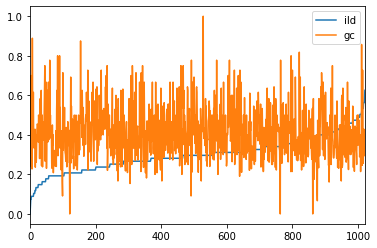

In [24]:
df_metrics=df_metrics.sort_values('ild')

df_metrics=df_metrics.reset_index(drop=True)

df_metrics.plot()

In [25]:
df_metrics.corr()

,ild,gc
ild,1.000000,-0.078031
gc,-0.078031,1.000000


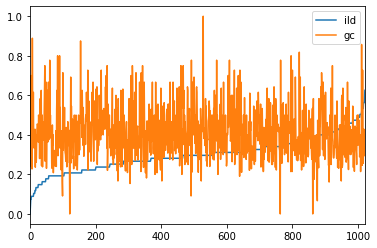

In [26]:
### df_metrics=df_metrics.sort_values('gc')

df_metrics=df_metrics.reset_index(drop=True)

df_metrics.plot()